In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def load_img(path, gray=False):
    """
    OpenCVを用いて画像を読み込む関数．
    
    Parameters
    ----------
    path : str
        画像へのパス
    gray : True or False
        グレー画像として読み込むかの設定
    
    returns
    ----------
    img : object
        読み込んだ画像
    """
    if gray:
        img = cv2.imread(path, 0)  # IMREAD_GRAYSCALE
    else:
        img = cv2.imread(path, 1)  # IMREAD_COLOR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 色空間の変換
    
    return img

In [5]:
def make_mask(img):
    """
    watershedアルゴリズムを用いて，マスク画像を生成する関数．
    
    Parameters
    ----------
    img : object
        対象とする画像(OpenCVで読み込んだBGRカラー画像)
    
    returns
    ----------
    mask : object
        対象のマスク画像
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 大津の閾値処理
    thresh, bin_img = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # ノイズ除去(opening: 収縮後に膨張)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 距離変換を行う(オブジェクトと背景の距離を出す)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    # 膨張させて，明確な背景(sure background)情報を得る
    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    # 明確な前景(sure foreground)を出す
    ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    # 背景でも前景でもないunknownな境界部分を抽出
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # foregroundの1オブジェクトごとにラベリング
    ret, markers = cv2.connectedComponents(sure_fg)

    # 0をunknown境界として用いるため，1を足して，1:背景 2以降:物体とする
    markers += 1
    markers[unknown == 255] = 0

    # 各情報からwatershedを実行
    markers = cv2.watershed(img, markers)
    
    # マスク画像を生成
    height, width, _ = img.shape
    mask = np.zeros((height, width))  # 原型を作成

    for i in range(2, 14):            # 1は背景のため除外
        mask[markers == i] = 255      # 領域部分を白に
#     mask[markers == i] = 255          # -1も境界のため白に
    
    return mask

In [7]:
# 保存先ディレクトリがなければ作成
save_dir = './datasets/train/images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
dataset_path = './datasets/shrimp/tray_train/'
images_path = glob.glob(os.path.join(dataset_path, '*.JPG'))

## 大津の閾値でのマスク画像の作成

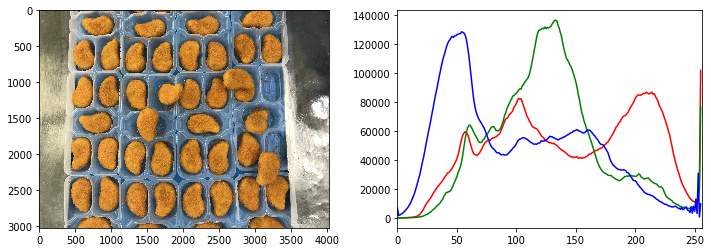

In [85]:
plt.figure(figsize=(12, 4))

# 元画像の読み込みと表示
img = load_img(images_path[0])  # トレー部分は[100:, 600:3300, :]
plt.subplot(121); plt.imshow(img)

# RGBのカラーヒストグラムの表示
plt.subplot(122)
color = ('r', 'g', 'b')
for i, c in enumerate(color):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=c)
    plt.xlim([0, 256])

plt.show()

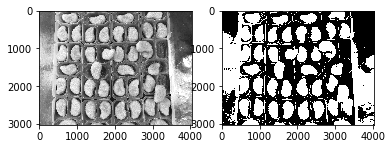

In [86]:
img = load_img(images_path[0])
img = img[:, :, 0]  # R成分のみ抽出

# 大津の閾値処理
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret,thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(121); plt.imshow(img, cmap='gray')
plt.subplot(122); plt.imshow(thresh, cmap='gray')

## 特定の色のみを抽出してマスクを作成

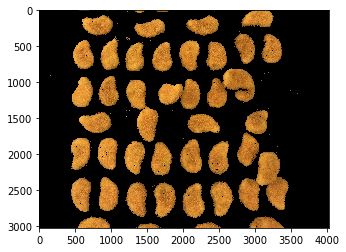

In [90]:
img = load_img(images_path[0])

# RGBでの色抽出
shrimp_lower = np.array([120, 41, 1])    # 下限141 63
shrimp_upper = np.array([255, 188, 87])  # 上限
shrimp_mask = cv2.inRange(img, shrimp_lower, shrimp_upper)  # マスク
shrimp = cv2.bitwise_and(img, img, mask=shrimp_mask)
plt.imshow(shrimp)

## Watershedを試してみる

In [12]:
images_path[0]

'./datasets/shrimp/tray_train\\IMG_0720.JPG'

大津法の二値化によって自動で決定された閾値: 143.0


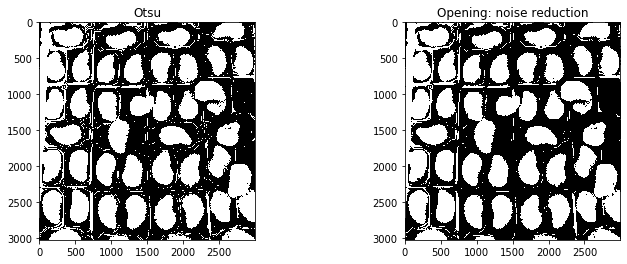

In [62]:
img = load_img(images_path[0], gray=False)[:, 400:3400, :]
red = img[:, :, 0]  # R成分のみ抽出
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 大津の閾値処理
thresh, bin_img = cv2.threshold(red, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print('大津法の二値化によって自動で決定された閾値:', thresh)

# ノイズ除去(opening: 収縮後に膨張)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.imshow(bin_img, cmap='gray'); plt.title('Otsu')
plt.subplot(122); plt.imshow(opening, cmap='gray'); plt.title('Opening: noise reduction')
plt.show()

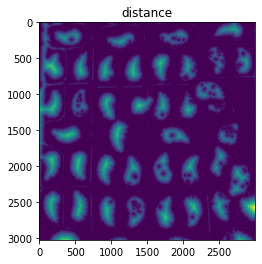

In [63]:
# 距離変換を行う(オブジェクトと背景の距離を出す)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(dist_transform)
plt.title('distance')
plt.show()

閾値(距離変換で得られた値の最大値×0.5): 91.58130645751953


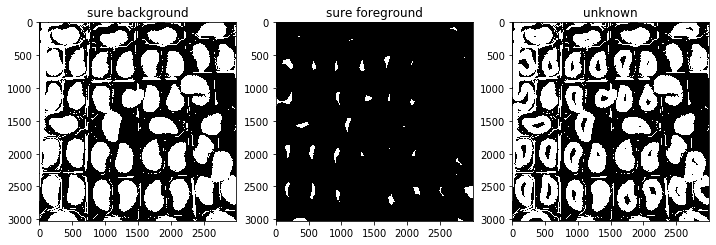

In [64]:
# 膨張させて，明確な背景(sure background)情報を得る
sure_bg = cv2.dilate(opening, kernel, iterations=2)

# 明確な前景(sure foreground)を出す
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
print('閾値(距離変換で得られた値の最大値×0.5):', ret)

# 背景でも前景でもないunknownな境界部分を抽出
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.imshow(sure_bg, cmap='gray'); plt.title('sure background')
plt.subplot(132); plt.imshow(sure_fg, cmap='gray'); plt.title('sure foreground')
plt.subplot(133); plt.imshow(unknown, cmap='gray'); plt.title('unknown')
plt.show()

before watershed : 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32), array([8850914,    2989,     518,     899,    7851,     224,   15257,
             1,    8596,    5133,    1098,    5212,   17563,    7366,
          2759,    6857,    3369,   10221,   10067,     489,     304,
          9860,   12125,    9616,      77,    3350,    2233,    2740,
             3,       3,     392,    9107,   10030,   17505,    3045,
          8020,    6840,    8866,    8243,    2258], dtype=int64))
add unknown : 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int32), array([4379495, 4471419,    2989,     518,     899,    7851,     224,
         15257,       1,    8596,    5133,    1098,    5212,   17563,
        

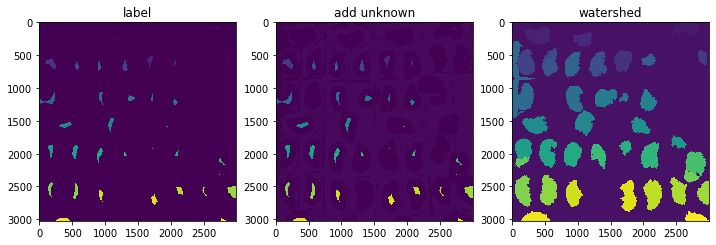

In [67]:
plt.figure(figsize=(12, 4))

# foregroundの1オブジェクトごとにラベリング
ret, markers = cv2.connectedComponents(sure_fg)
plt.subplot(131); plt.imshow(markers); plt.title('label')

# markersのデータの中身，0:背景 1以降:物体
print('before watershed : \n', np.unique(markers, return_counts=True))

# 0をunknown境界として用いるため，1を足して，1:背景 2以降:物体とする
markers += 1
markers[unknown == 255] = 0
plt.subplot(132); plt.imshow(markers); plt.title('add unknown')

# 0:unknown 1:背景 2以降:物体
print('add unknown : \n', np.unique(markers, return_counts=True))

# 各情報からwatershedを実行
markers = cv2.watershed(img, markers)
plt.subplot(133); plt.imshow(markers); plt.title('watershed')

# watershed実行後は-1:境界 1:背景 2以降:物体
print('after watershed : \n', np.unique(markers, return_counts=True))

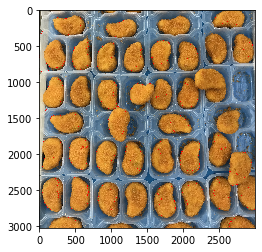

In [69]:
# 境界の領域を青で塗る
img[markers == -1] = [255, 0, 0]
plt.imshow(img)

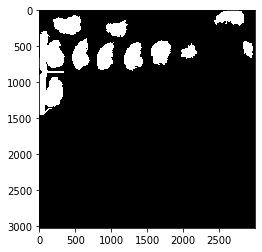

In [70]:
# マスク画像を生成
height, width, _ = img.shape
mask = np.zeros((height, width))  # 原型を作成

for i in range(2, 14):            # 1は背景のため除外
    mask[markers == i] = 255      # 領域部分を白に
mask[markers == i] = 255          # -1も境界のため白に

plt.imshow(mask, cmap='gray')

## マスク画像の保存

In [7]:
save_dir = './datasets/train/masks/'
RoI_dir = './datasets/train/images/'
RoI_images_path = glob.glob(os.path.join(RoI_dir, '*.png'))
for path in RoI_images_path:
    img = load_img(path)
    mask = make_mask(img)
    
    file_name = path[-12:]  # ファイル名(.pngの部分)
    save_path = os.path.join(save_dir, 'train_' + file_name)
    cv2.imwrite(save_path, mask)